# Train a deep network

In [1]:
#increase the number of features

In [160]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 
#inline

import matplotlib as mpl
mpl.style.use('mg')
%run "./t00_helper_functions.py"

In [4]:
path='/Users/mgao1/OneDrive - NASA/data/mapol_test1/test002_simulator/harp/'
#file='input_test_t101_output.h5'
file='input_test_t101_441_n1000_output.h5'
filename=path+file
rt1=RTData(filename)

solzen:15.07, wind:5.76, aod:0.19, chla:0.0748


<IPython.core.display.Javascript object>


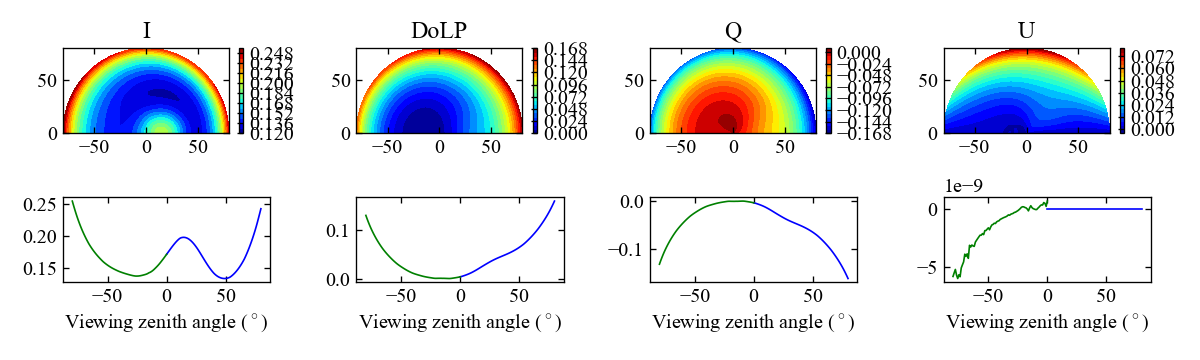

In [9]:
id1=1
rt1.print_par(id1)
stokesv=rt1.stokesv[:,:,:,id1]
outfile='/Users/mgao1/Desktop/stokes.pdf'
plot_stokesv(rt1.theta, rt1.phi, stokesv, outfile)

<IPython.core.display.Javascript object>


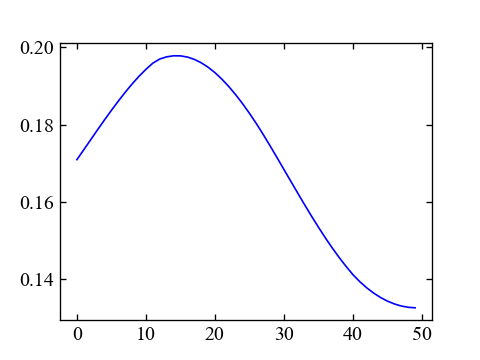

In [10]:
fig=plt.figure()
plt.plot(stokesv[0,0,:50])

In [16]:
rt1.stokesv.shape

(3, 91, 81, 1000)

In [17]:
dat1=np.array([rt1.stokesv[0,0,:,i] for i in range(len(rt1.stokesv[0,0,0]))])
x1=rt1.wndspd[:]
x2=rt1.solzen[:]
y1=dat1
xv1=np.array([x1,x2]).T
xv1.shape

(1000, 2)

In [19]:
y1.shape, x1.shape

((1000, 81), (1000,))

## test

In [21]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

#import imageio

#from torchviz import make_dot

In [22]:
# torch can only train on Variable, so convert them to Variable
x=torch.from_numpy(xv1)
y=torch.from_numpy(y1)
x, y=Variable(x).float(),Variable(y).float()
print(x.shape,y.shape)

torch.Size([1000, 2]) torch.Size([1000, 81])


In [123]:
# this is one way to define a network
class Net1(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net1, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
    
# this is one way to define a network
class Net2(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2,n_output):
        super(Net2, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden2, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x

In [126]:
batch_size = 64
epochs = 5000
torch_dataset = Data.TensorDataset(x, y)

ny=1000
yratio=0.7
ny1=np.int(1000*yratio)
ny2=np.int(ny-ny1)
print(ny1, ny2)

train_set, test_set = torch.utils.data.random_split(torch_dataset, [ny1, ny2])

trainloader = Data.DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True, num_workers=2,)

testloader = Data.DataLoader(
    dataset=test_set, 
    batch_size=batch_size, 
    shuffle=True, num_workers=2,)

700 300


In [127]:
learning_rate=0.01
#net = Net1(n_feature=2, n_hidden1=100, n_output=1)     # define the network
net = Net2(n_feature=2, n_hidden1=10,n_hidden2=10, n_output=81)     # define the network
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
net.apply(init_weights)

# print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

In [128]:
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader): # for each training step
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        
        prediction = net(b_x)     # input x and predict based on x
        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for step, (batch_x, batch_y) in enumerate(testloader):
                b_x = Variable(batch_x)
                b_y = Variable(batch_y)
                prediction = net(b_x)
                loss = loss_func(prediction, b_y)
                test_loss += loss.item()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    if (e==0 or e % 100 == 99):
        #print(epoch, loss.item())
        print("Epoch: {}/{}.. ".format(e+1, epochs),
      "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/5000..  Training Loss: 1.896..  Test Loss: 0.226..  Test Accuracy: 0.000
Epoch: 100/5000..  Training Loss: 0.130..  Test Loss: 0.142..  Test Accuracy: 0.000
Epoch: 200/5000..  Training Loss: 0.106..  Test Loss: 0.118..  Test Accuracy: 0.000
Epoch: 300/5000..  Training Loss: 0.086..  Test Loss: 0.099..  Test Accuracy: 0.000
Epoch: 400/5000..  Training Loss: 0.064..  Test Loss: 0.075..  Test Accuracy: 0.000
Epoch: 500/5000..  Training Loss: 0.048..  Test Loss: 0.053..  Test Accuracy: 0.000
Epoch: 600/5000..  Training Loss: 0.040..  Test Loss: 0.044..  Test Accuracy: 0.000
Epoch: 700/5000..  Training Loss: 0.037..  Test Loss: 0.039..  Test Accuracy: 0.000
Epoch: 800/5000..  Training Loss: 0.034..  Test Loss: 0.037..  Test Accuracy: 0.000
Epoch: 900/5000..  Training Loss: 0.033..  Test Loss: 0.036..  Test Accuracy: 0.000
Epoch: 1000/5000..  Training Loss: 0.031..  Test Loss: 0.035..  Test Accuracy: 0.000
Epoch: 1100/5000..  Training Loss: 0.030..  Test Loss: 0.034..  Test Accuracy

In [129]:
train_losses=np.array(train_losses)
test_losses=np.array(test_losses)

<IPython.core.display.Javascript object>


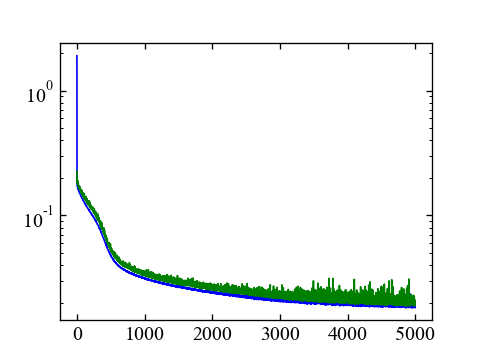

In [132]:
#%matplotlib inline
fig=plt.figure()
ax=plt.subplot(111)
ax.set_yscale('log')
plt.plot(train_losses,'b')
plt.plot(test_losses,'g')
plt.show()

<IPython.core.display.Javascript object>


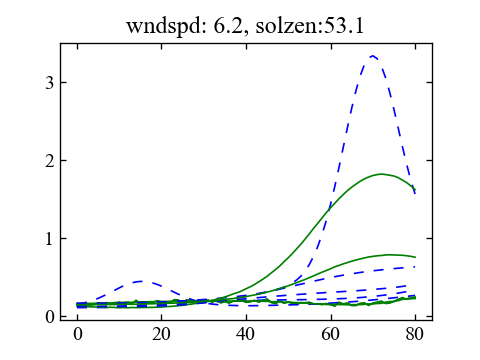

In [159]:
fig=plt.figure()
ax=plt.subplot(111)

for id1 in [10,20,30,40,60]:
    plt.plot(rt1.stokesv[0,0,:,id1],'b--')
    input1=torch.from_numpy(np.array([rt1.wndspd[id1],rt1.solzen[id1]])).float()
    prediction = net(input1)
    plt.plot(prediction.data.numpy(),'g-')
    plt.title("wndspd: %3.1f, solzen:%3.1f" %(rt1.wndspd[id1],rt1.solzen[id1]))